In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import newton_krylov
import obspy
# from scipy.signal import find_peaks_cwt
%matplotlib inline

# Love Wave mode summation following Haskell (1951)
Model has $n$ layers, where the $n$th is the lower half-space and the zero-th is the free half-space. The layer boundaries $0$ to $n-1$ are above the $n$ layers.
## Theory
Displacement and stress within a homogeneous layer:
$$v = \exp[i(pt-kx)][v'\exp(-ikr_\beta z)+v''\exp(ikr_\beta z)]$$
$$Y_z = \mu\partial v/\partial z = ik\mu r_\beta \exp[i(pt-kx)][-v'\exp(-ikr_\beta z)+v''\exp(ikr_\beta z)]$$
Note that $p$ is the angular frequency, usually $\omega$.

Place the $z$ origin at the $(m-1)$th interface so that:
$$(\dot v/c)_{m-1} = ik(v_m'+v_m'')$$
$$(Y_z)_{m-1} = ik\mu_m r_{\beta m}(v_m''-v_m')$$

and at the $m$th interface (next one down, $z = d_m$):
$$(\dot v/c)_{m} = (v_m'+v_m'')ik\cos Q_m - (v_m''-v_m')\
sin Q_m$$
$$(Y_z)_{m} = -(v_m'-v_m'')k\mu_m r_{\beta m}\sin Q_m + (v_m''-v_m')k\mu_m r_{\beta m}\cos Q_m$$
where $Q = kr_{\beta m}d_m$

Eliminate the constants $v_m'$ and $v_m''$ to find:
$$(\dot v_m/c)_m = (\dot v/c)_{m-1}\cos Q_m + (Y_z)_{m-1}\mu_m^{-1}r_{\beta m}^{-1}i\sin Q_m$$
$$(Y_z)_m = (\dot v/c)_{m-1}i\mu_m r_{\beta m}\sin Q_m + (Y_z)_{m-1}\cos Q_m$$

So the propagator matrix (with a time derivative so that $l_1$ is replaced by $l_1 ik/c$) is:
$$a_m = \begin{bmatrix} \cos Q_m & i\mu_m^{-1}r_{\beta m}^{-1}\sin Q_m \\ i\mu_mr_{\beta m}\sin Q_m & \cos Q_m \end{bmatrix}$$

The combined propagation through all layers $A = a_{n-1}a_{n-2}...a_1$ leads to the equations at the lowest interface:
$$(\dot v/c)_{n-1} = A_{11}(\dot v/c)_0 + A_{12}(Y_z)_0$$
$$(Y_z)_{n-1} = A_{21}(\dot v/c)_0 + A_{22}(Y_z)_0$$

The coefficients in the lower half space are:
$$v_n'+v_n'' = A_{11}(ik)^{-1}(\dot v/c)_0 + A_{12}(ik)^{-1}(Y_z)_0$$
$$v_n''-v_n' = A_{21}(ik\mu_n r_{\beta n})^{-1}(\dot v/c)_0 + A_{22}(ik\mu_n r_{\beta n})^{-1}(Y_z)_0$$

The boundary conditions call for $(Y_z)_0 = 0$ and $v_n'' = 0$, so the dispersion relation is:
$$A_{21} = -\mu_n r_{\beta n}A_{11}$$

## Computation process
1. Find k(c) over the range of acceptable phase velocities (vs_min to vs_max)
2. Find $(\dot v/c)\cdot c/ik = l_1$ throughout the model at a range of frequencies
3. Plot $l_1$ and check boundary conditions and bounded-ness

In [9]:
# One layer over half-space
dm = np.array([40, 100])*100000 #cm
B = np.array([2.4, 3.5])*100000 #cm/s
rho = np.array([2.0, 2.67]) #g/cc
mu = (B**2)*rho 

# Bounds on phase velocity
cmin = min(B)
cmax = max(B)
c = np.linspace(cmin,cmax,100)

# Bounds on frequency TRY WITHOUT
# omega_max = 1.0
# n_omega = 100
# omega = np.linspace(.01,omega_max,n_omega)
# determine k_test values for given omega
# omega_test = omega[1]
# k_test = np.linspace(omega_test/c[-1],omega_test/c[0],1000)
k_test = np.linspace(27e-7,40e-7,1e5)

# r_b is a function of c and layer velocity
r_b = np.zeros((len(c),len(B)),dtype=complex)
for ci in range(len(c)):
    for bi in range(len(B)):
        if c[ci]>=B[bi]:
            r_b[ci,bi] = np.sqrt((c[ci]/B[bi])**2-1)
        else:
            r_b[ci,bi] = 1j*np.sqrt(1-(c[ci]/B[bi])**2) #FIXED positive not negative, Haskell wrong?
            
# Make A matrix as a function of k and c (index)
def A_mat(k,ci):
    # TODO solve case for ci=0 (currently sets a[0,1]=0)
    #calculate each a_m matrix and multiply
    A = np.ones((2,2),dtype=complex)
    a_m = np.zeros((2,2),dtype=complex)
    for m in [1]:
        Q_m = k*r_b[ci,m]*dm[m]
        if Q_m == np.real(Q_m):
            a_m[0,0] = np.cos(Q_m)
            a_m[1,1] = np.cos(Q_m)
            a_m[0,1] = 1j*np.sin(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sin(Q_m)
        else:
            a_m[0,0] = np.cosh(Q_m)
            a_m[1,1] = np.cosh(Q_m)
            a_m[0,1] = 1j*np.sinh(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sinh(Q_m)
        if ci == len(c)-1:
            a_m[0,1] = 0
        A = np.multiply(a_m,A)
    return A

# check dispersion relation
ci_test = 0
# k_test = np.array(range(50))+1
check_zero = np.zeros(len(k_test),dtype=complex)
for ki in range(len(k_test)):
    A = A_mat(k_test[ki],ci_test)
    check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
print A

[[-0.66709148 -0.00000000e+00j  0.00000000 -3.12925185e-12j]
 [ 0.00000000 +1.77355159e+11j -0.66709148 -0.00000000e+00j]]


/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


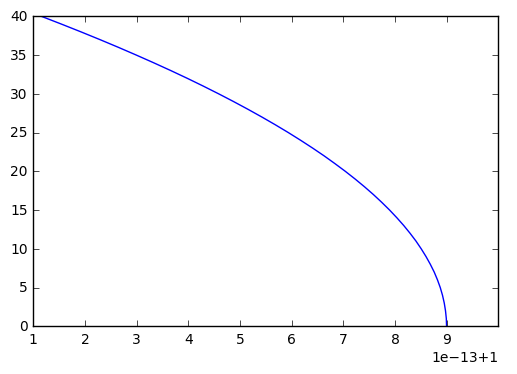

In [410]:
#Use propagator matrix to get l1, l2
#Choose longest period, first values
ci = 1
m = 0
k_use = k_of_c[ci]
c_use = c[ci]
omega = k_use*c_use
z_list = range(0,41)
l1 = np.zeros(41)
for z in z_list:
    #all inside first layer
    #dm in Qm is the depth within the layer, down from layer interface
    a_z = np.zeros((2,2),dtype=complex)
    Q_z = k_use*r_b[ci,m]*z
    #Q_z all real in the upper layer
    a_z[0,0] = np.cos(Q_z)
    a_z[1,1] = np.cos(Q_z)
    a_z[0,1] = 1j*np.sin(Q_z)/(mu[m]*r_b[ci,m])
    a_z[1,0] = 1j*mu[m]*r_b[ci,m]*np.sin(Q_z)
    #use propagator
    f = np.matrix(a_z)*np.matrix([[1],[0]])
#     print f
#     print f[0,0]*c_use/(1j*k_use)
    
    l1[z] = f[0,0]#*c_use/(k_use)
plt.plot(l1,z_list)

In [411]:
# f=np.matrix(a_z)*np.matrix([[1],[0]])
l1[0]

1.0

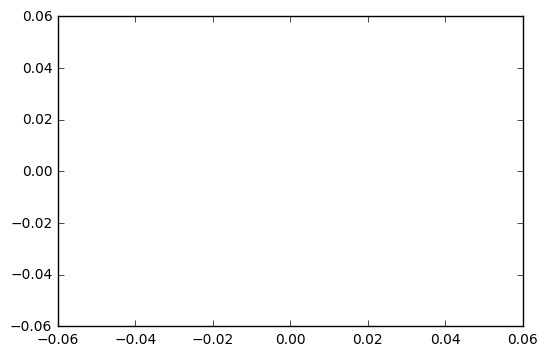

In [355]:
plt.plot(k_test,np.abs(check_zero))
# plt.plot(k_test[get_k_ind],0,'x')

In [352]:
np.argmin(abs(check_zero))
# (2*np.pi)/(k_test[64741]*c[ci_test])

19950

In [353]:
k_of_c[ci_test] = k_test[np.argmin(abs(check_zero))]
print k_of_c[ci_test]

2.95935259353e-06


In [312]:
for ci_test in range(70,80):
    check_zero = np.zeros(len(k_test),dtype=complex)
    for ki in range(len(k_test)):
        A = A_mat(k_test[ki],ci_test)
        check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
    k_of_c[ci_test] = k_test[np.argmin(abs(check_zero))]

In [11]:
low_k_bound = 1.5e-6
low_k_ind = np.argwhere(k_test>low_k_bound)[0,0]
thresh = abs(check_zero[low_k_ind])
print thresh
hi_k_ind = low_k_ind+np.argwhere(abs(check_zero[low_k_ind:])>thresh)[0,0]
print hi_k_ind
get_k_ind = low_k_ind+np.argmin(abs(check_zero[low_k_ind:hi_k_ind]))
get_k = k_test[get_k_ind+10]
get_k

1.1921209792
2


0.00022002200220022004

In [628]:
#save 4km layer results
k_of_c_4km = k_of_c

In [682]:
ci_list = np.array(range(len(c)-1)) #ci=0 works, last doesn't
k_of_c = np.zeros(ci_list.size)
low_k_bound = 1.5e-6
for ci in ci_list:
#     def check_dissipation(k):
#         A = A_mat(k,ci)
#         return abs(A[1,0]/(mu[-1]*r_b[ci,-1]) + A[0,0])
#     k_of_c[ci-1] = newton_krylov(check_dissipation,2e-6)
    for ki in range(len(k_test)):
        A = A_mat(k_test[ki],ci)
        check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
    # find zero of first mode, near 2.5e-6
    low_k_ind = np.argwhere(k_test>low_k_bound)[0,0]
    thresh = abs(check_zero[low_k_ind])
    hi_k_ind = low_k_ind+np.argwhere(abs(check_zero[low_k_ind:])>thresh)
    if not hi_k_ind.any():
        break
    else: hi_k_ind = hi_k_ind[0,0]
    get_k_ind = low_k_ind+np.argmin(abs(check_zero[low_k_ind:hi_k_ind]))
    k_of_c[ci] = k_test[get_k_ind]
    if thresh>1.2:
        low_k_bound += .1e-6

In [358]:
[k_of_c[n]/k_of_c[n-1] for n in range(1,99)]

[1.0041395203716919,
 1.0041993668646882,
 1.0042583957795927,
 1.0043013508071896,
 1.0043740545663307,
 1.0044154917224652,
 1.004486411292508,
 1.0045413124542872,
 1.0046103026089239,
 1.0046782548772664,
 1.0047303829540648,
 1.0048111017275827,
 1.004875920275043,
 1.0049396891638667,
 1.0050169066855357,
 1.005078427072633,
 1.0051676025769112,
 1.0052267196764575,
 1.0053274007398694,
 1.0053839566570293,
 1.0054816239100002,
 1.0055635700786167,
 1.0056439998443034,
 1.0057367350098423,
 1.0058277140791523,
 1.0059305983345133,
 1.0060178933841208,
 1.0061169264672523,
 1.006213947695471,
 1.0063222928848863,
 1.0064283707195003,
 1.0065453472721575,
 1.0066467090939542,
 1.0067717919123229,
 1.0068940765165033,
 1.0070135578355672,
 1.0071429662790876,
 1.0072819400301896,
 1.0074175596605242,
 1.0075498213458118,
 1.007703455302648,
 1.0078531654392004,
 1.008011123042571,
 1.0081769407854211,
 1.0083382452306675,
 1.0085069172167649,
 1.0086943409029863,
 1.008888027208342,

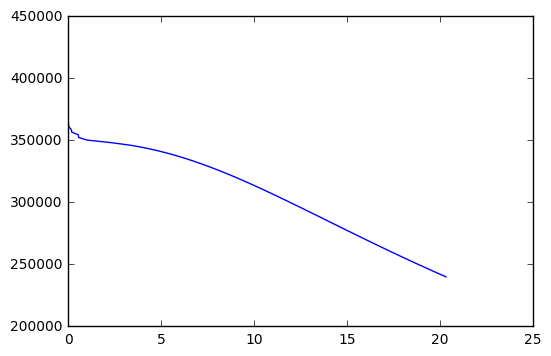

In [602]:
plt.plot(2*np.pi/(k_of_c[:-1]*c[:-1]),c[:-1])

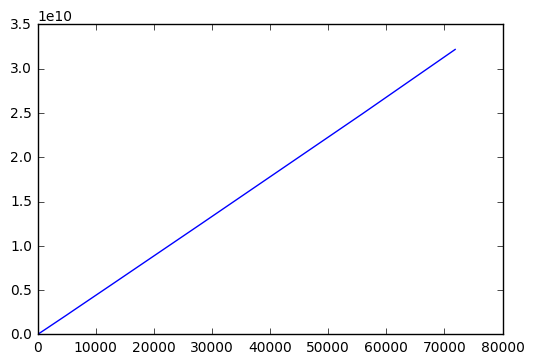

In [601]:
plt.plot(k_of_c[:-1],c[:-1]*k_of_c[:-1])

In [512]:
max(k_of_c)/min(k_of_c)

9.1419237648628862

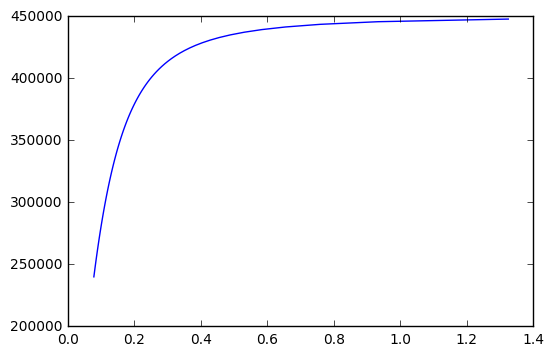

In [600]:
plt.plot(c[:-1]*k_of_c[:-1],c[:-1])

## non-dimensional version
I got confused trying to re-dimensionalize once solved. It's also out of date now

In [43]:
# # Two layers over half-space (non-dimensionalized)
dm = np.array([4, 21, 100])*100000
B = np.array([2.4, 3.5, 4.5])*100000
rho = np.array([2.0, 2.67, 3.3])
mu = (B**2)*rho


# Bounds on phase velocity
cmin = min(B)
cmax = max(B)
c = np.linspace(cmin,cmax,100)

k_test = np.linspace(0,3e-6,1e5)

# r_b is a function of c and layer velocity
r_b = np.zeros((len(c),len(B)),dtype=complex)
for ci in range(len(c)):
    for bi in range(len(B)):
        if c[ci]>B[bi]:
            r_b[ci,bi] = np.sqrt((c[ci]/B[bi])**2-1)
        else:
            r_b[ci,bi] = 1j*np.sqrt(1-(c[ci]/B[bi])**2) #FIXED to positive not negative, Haskell is wrong?
            
# Make A matrix as a function of k and c (index)
def A_mat(k,ci):
    # TODO solve case for ci=0 (currently sets a[0,1]=0)
    #calculate each a_m matrix and multiply
    A = np.ones((2,2),dtype=complex)
    a_m = np.zeros((2,2),dtype=complex)
    for m in [1]:
        Q_m = k*r_b[ci,m]*dm[m]
        if Q_m == np.real(Q_m):
            a_m[0,0] = np.cos(Q_m)
            a_m[1,1] = np.cos(Q_m)
            a_m[0,1] = 1j*np.sin(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sin(Q_m)
        else:
            a_m[0,0] = np.cosh(Q_m)
            a_m[1,1] = np.cosh(Q_m)
            a_m[0,1] = 1j*np.sinh(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sinh(Q_m)
        if ci == len(c)-1:
            a_m[0,1] = 0
        A = np.multiply(a_m,A)
    return A

# check dispersion relation
ci_test = 0
check_zero = np.zeros(len(k_test),dtype=complex)
for ki in range(len(k_test)):
    A = A_mat(k_test[ki],ci_test)
    check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
print A

[[-0.12646333 -0.00000000e+00j  0.00000000 -4.16675001e-12j]
 [ 0.00000000 +2.36156962e+11j -0.12646333 -0.00000000e+00j]]


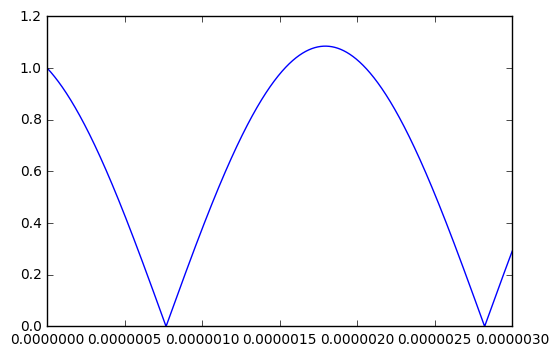

In [44]:
plt.plot(k_test,np.abs(check_zero))
# plt.plot(k_test[get_k_ind],0,'x')

In [571]:
k_now=k_of_c2[50]
k_test = np.linspace(.98*k_now,2.5*k_now,1e5)
ci_test = 51
check_zero = np.zeros(len(k_test),dtype=complex)
for ki in range(len(k_test)):
    A = A_mat(k_test[ki],ci_test)
    check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
print A

[[-0.96224936 -0.00000000e+00j  0.00000000 +8.17442204e-12j]
 [ 0.00000000 -9.06194691e+09j -0.96224936 -0.00000000e+00j]]


In [533]:
np.argmin(abs(check_zero))
# k_test[np.argmin(abs(check_zero))]
# (2*np.pi)/(k_test[64741]*c[ci_test])

48382

In [545]:
k_of_c2[ci_test] = k_test[np.argmin(abs(check_zero))]
print k_of_c2[ci_test]

2.94887348873e-05


In [596]:
k_test = np.linspace(1e-6,1.5e-6,1e5)
k_now = k_of_c2[54]
k_test = np.linspace(.98*k_now,3*k_now,1e5)
for ci_test in range(55,65):
    check_zero = np.zeros(len(k_test),dtype=complex)
    for ki in range(len(k_test)):
        A = A_mat(k_test[ki],ci_test)
        check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
    k_now = k_test[np.argmin(abs(check_zero))]
    k_of_c2[ci_test] = k_now
    if ci_test<40:
        k_test = np.linspace(.95*k_now,1.5*k_now,1e5)
    else:
        k_test = np.linspace(.95*k_now,3.5*k_now,1e5)

In [560]:
# [k_of_c2[n]/k_of_c2[n-1] for n in range(1,55)]
k_now=k_of_c2[20]

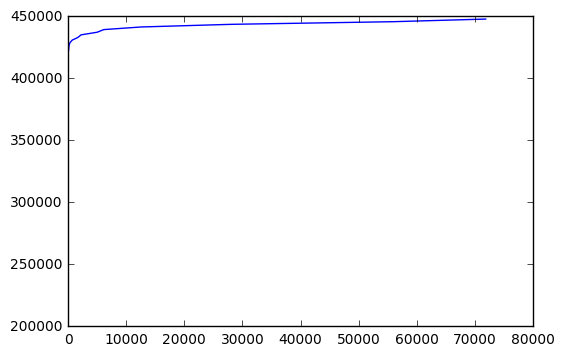

In [605]:
n=99
plt.plot(k_of_c2[:n],c[:n])
# plt.plot(2*np.pi/(k_of_c2*c[:-1]),c[:-1])

## 2-layer analytic dispersion
$$\tan Q_1 = -i(\mu_2 r_{\beta 2}/\mu_1 r_{\beta 1})$$

In [2]:
# One layer over half-space
dm = np.array([40, 100])*100000
B = np.array([2.4, 3.5])*100000
rho = np.array([2.0, 2.67])
mu = (B**2)*rho

In [3]:
# 130 equation for dispersion
c_range = np.linspace(B[0],B[1],(B[1]-B[0])/10)
T_analytic = np.zeros(c_range.shape)
for c_ind in range(len(c_range)):
    c = c_range[c_ind]
    T_analytic[c_ind] = 2*np.pi*dm[0]*np.sqrt(B[0]**-2-c**-2)/np.arctan(np.sqrt(c**-2-B[1]**-2)*mu[1]/(np.sqrt(B[0]**-2-c**-2)*mu[0]))
#     print T_analytic[c_ind]
omega_a = 2*np.pi/T_analytic
k_a = omega_a/c_range

/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in double_scalars
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


In [5]:
#haskell analytic relation
# r_b is a function of c and layer velocity
r_b = np.zeros((len(c_range),len(B)),dtype=complex)
for ci in range(len(c_range)):
    for bi in range(len(B)):
        if c_range[ci]>=B[bi]:
            r_b[ci,bi] = np.sqrt((c_range[ci]/B[bi])**2-1)
        else:
            r_b[ci,bi] = 1j*np.sqrt(1-(c_range[ci]/B[bi])**2)
k_ha = np.arctan(-1j*mu[1]*r_b[:,1]/(mu[0]*r_b[:,0]))/(r_b[:,0]*dm[0])
T_ha = 2*np.pi/(c_range*k_ha)

/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in multiply
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in divide
/home/jes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


/home/jes/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


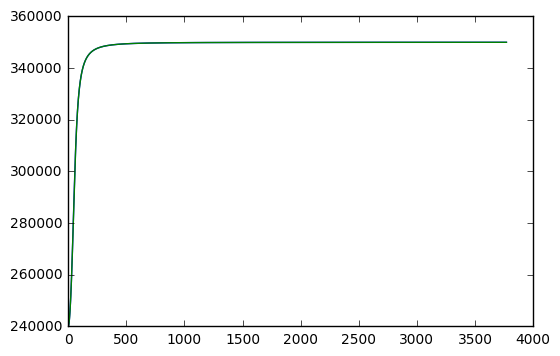

In [7]:
plt.plot(T_analytic,c_range)
plt.plot(T_ha,c_range)